In [1]:
# Initial setup, other dependencies imported as needed
import numpy as np
np.random.seed(1234567)

import matplotlib.pyplot as plt
%matplotlib inline

# Mean-Variance Portfolio Building Demonstration

With a limited universe of investable securities we show how someone is able to build an optimal portfolio.  By optimal we mean according to the framework from the 1952 seminal paper 'Portfolio Selection' by Harry Markowitz.  

We take the adjusted-close from Yahoo Finance of a random subset of publicly traded securities.  In our universe of assets we have four equities: Disney (DIS), Google (GOOG), Toyota Motors (TM) and Walmart (WMT), as well as one commodity future: Gold (GC=F).

In [2]:
import pandas as pd
import yfinance as yf

# Note, tickers download in alphabetical order
tickers = ['DIS', 'GC=F', 'GOOG', 'TM', 'WMT']
start_date = '2009-01-01'
end_date = '2019-01-31'

df_closes = pd.DataFrame(yf.download(tickers, start=start_date, end=end_date)['Adj Close'])
df_closes.head()

[*********************100%***********************]  5 of 5 completed


,DIS,GC=F,GOOG,TM,WMT
Date,,,,,
2009-01-02,20.597496,878.799988,160.060059,48.652241,42.877636
2009-01-05,20.235834,857.200012,163.412491,48.102455,42.382732
2009-01-06,20.933319,865.400024,166.406265,48.681561,42.007793
2009-01-07,19.960283,841.099976,160.403763,48.776859,41.647846
2009-01-08,19.719175,853.900024,161.987823,50.125648,38.528389


Before we proceed any further we must first take the adjusted closes and compute daily returns from these and before removing any `NA` values.

In [3]:
# Convert to returns
df_returns = df_closes.pct_change().dropna()
df_returns.head()

,DIS,GC=F,GOOG,TM,WMT
Date,,,,,
2009-01-05,-0.017559,-0.024579,0.020945,-0.011300,-0.011542
2009-01-06,0.034468,0.009566,0.018320,0.012039,-0.008847
2009-01-07,-0.046483,-0.028080,-0.036071,0.001958,-0.008569
2009-01-08,-0.012079,0.015218,0.009875,0.027652,-0.074901
2009-01-09,-0.025764,0.000468,-0.031120,-0.027055,0.003892


The crux of how portfolios are able to offer better returns for a given level of risk, versus investing in individual securities, is due to correlation between the portfolio holdings.  There are still many further details to consider but the below highlights that this correlation does exist (be it negative or positive) between the securities in our limited investment universe.

In [21]:
corr = df_returns.corr()
corr.style.background_gradient(cmap='Blues').set_precision(5)


,DIS,GC=F,GOOG,TM,WMT
DIS,1.000000,-0.023918,0.454219,0.473698,0.333682
GC=F,-0.023918,1.000000,-0.000211,-0.005478,-0.011778
GOOG,0.454219,-0.000211,1.000000,0.388009,0.245705
TM,0.473698,-0.005478,0.388009,1.000000,0.252644
WMT,0.333682,-0.011778,0.245705,0.252644,1.000000


## Building Random Portfolios

Our aim in this section is to show that portfolios are able to achieve similar returns for a much lower level of risk.  Within our framework we use the average return from the historical data as the expected return and the standard deviation of these returns as a proxy for the risk.

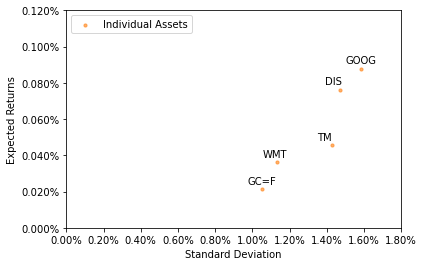

In [5]:
from matplotlib.ticker import StrMethodFormatter

# Compute the expected returns and standard deviation
stock_returns = df_returns.mean()
stock_sds = df_returns.std()

# Plot and format the graph
fig1 = plt.figure(figsize=(6,4))
plt.scatter(stock_sds, stock_returns, alpha=0.6, s=10,c='C1', label="Individual Assets")
for i, ticker in enumerate(tickers):
    plt.annotate(ticker, 
                 (stock_sds[i], stock_returns[i]),
                 textcoords="offset points",
                 xytext=(-15,5))
plt.xlim(0, 0.018)
plt.ylim(0, 0.0012)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')    
plt.show()

In the next step we define two functions.  The first, `rand_weights`, generates random weights (summing to 1) that we can assign to each security within our portfolio.  The second `rand_portfolio` takes a data frame of returns, generates a randomly weighted portfolio and then computes the expected return and standard deviation of that portfolio.

We compute the portfolio expected returns and standard deviation using vectors and matrices.  For a portfolio $P$, made up of $N$ assets (in our case $N=5$) with weights vector $w$, expected returns vector $R$ and covariance matrix of returns $\Sigma$, we have the following.

$$
\begin{alignat*}{2}
&\mathbb{E}[R_P] = R^Tw \quad &&\text{(Portfolio Expected Return)} \\
&\sigma_P^2 = w^T\Sigma w \quad &&\text{(Portfolio Variance)} \\
&\sigma_P = \sqrt{\sigma_P^2} \quad &&\text{(Portfolio Standard Deviation)}
\end{alignat*}
$$

In [6]:
# Draw random weights to generate a portfolio
def rand_weights(n):
    w = np.random.rand(n)
    
    return w / sum(w)

# Given a list of returns computes the expected return and standard deviation of a random portfolio
def rand_portfolio(returns):
    R_vec = np.array(np.mean(returns))
    w = np.array(rand_weights(returns.shape[1]))
    Sigma_mat = np.asmatrix(np.cov(returns, rowvar=False))
    expected_return = R_vec.T @ w 
    standard_deviation = np.sqrt(w.T @ Sigma_mat @ w).item()
    
    return expected_return, standard_deviation

We use the two functions we have just written to generate 1000 random portfolios and compute their expected return and standard deviation before plotting these alongside the earlier plot containing just the individual assets.

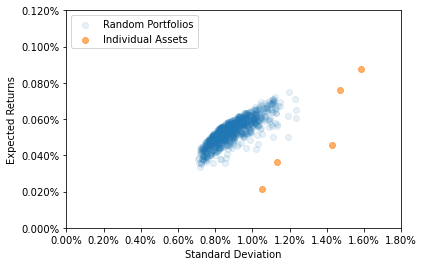

In [7]:
# Compute the means and sds for 1000 random portfolios
n_portfolios = 1000
portfolio_returns, portfolio_sds = np.column_stack([
    rand_portfolio(df_returns) 
    for _ in range(n_portfolios)
])

fig2 = plt.figure(figsize=(6,4))
plt.scatter(portfolio_sds, portfolio_returns, alpha=0.1, c='C0', label="Random Portfolios")
plt.scatter(stock_sds, stock_returns, alpha=0.6, c='C1', label="Individual Assets")
plt.xlim(0, 0.018)
plt.ylim(0, 0.0012)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')    
plt.show()

We can already see that even these random portfolios are able to offer similar returns for a much reduced risk versus the individual assets.

## The Efficient Frontier (Without Short Selling)

The efficient frontier shows us those portfolios that, for a given level of risk, offer the best returns.  Alternatively this can be thought about as the portfolios that, for a given level of returns, offer the lowest risk.  It should be clear that these two statements are identical.

In this section we prohibit short selling which means the initial mathematical problem we want to solve is (we choose to minimise risk for a given level of return, $m$), the factor of $\frac{1}{2}$ is to match standard notation and has no impact on the result:

$$
\begin{align*}
\text{min } &\frac{1}{2}w^T\Sigma w \\
\text{s.t. } &w^TR = m\\
&w^T\mathbf{1} = 1\\
&w \geqslant 0
\end{align*}
$$

We can use the concepts of Lagrangian multipliers to include the first constraint in the objective function.  We also remove constant term and perform a relabelling ($q = \lambda m$, where $\lambda$ is the Lagrangian multiplier).  This leaves us with a standardised convex optimisation problem,

$$
\begin{align*}
\text{min } &\frac{1}{2}w^T\Sigma w - qw^TR\\
\text{s.t. } &w^T\mathbf{1} = 1\\
&w \geqslant 0
\end{align*}
$$

To solve this convex optimisation problem we use the `cvxopt` module, see the example at https://cvxopt.org/userguide/coneprog.html#quadratic-programming.

In [8]:
import cvxopt as cp
cp.solvers.options['show_progress'] = False

def frontier_portfolios(returns):

    # n assets, Covariance matrix and Expected Returns
    n = returns.shape[1]
    Sigma = cp.matrix(np.cov(returns, rowvar=False))
    R_vec = cp.matrix(np.mean(returns))
    
    # Constraints
    # G.w <= h, weights must be non-negative (no short positions)
    # A.w = b, weights must sum to 1 (no leverage and full allocation)
    G = -cp.matrix(np.eye(n)) # G is negative identity matrix
    h = cp.matrix(0.0, (n,1)) # nx1 matrix of 0s
    A = cp.matrix(1.0, (1,n)) # 1xn matrix of 1s
    b = cp.matrix(1.0) # scalar of 1.0

    # Values of q to solve the frontier for (may need changing on a per-example basis)
    N = 200
    qs = [ 20**(5.0*t/N-1.0) for t in range(N) ]
    qs.insert(0, 0)
    qs.insert(1, 0.025)

    # Solver for portfolio weights
    portfolio_weights = [cp.solvers.qp(Sigma, -q*R_vec, G, h, A, b)['x'] for q in qs]
    expected_returns = [cp.blas.dot(R_vec, x) for x in portfolio_weights]
    standard_deviations = [np.sqrt(cp.blas.dot(x, Sigma*x)) for x in portfolio_weights]
    
    return expected_returns, standard_deviations, portfolio_weights

returns, risks, weights = frontier_portfolios(df_returns)
frontier_long = pd.DataFrame({'Risks':risks, 'Returns':returns, 'Weights':weights})

Now we have generated a selection of portfolios along the efficient frontier we are able to plot them.  Often you will see the bottom half of the efficient frontier plotted as well, this so-called 'inefficient frontier' is a lower bound on portfolio risks and reflects the top half.  By solving a slightly different optimisation problem, where the level of expected return is kept as an input, we can solve for this bottom half of the curve but for our illustrative purposes we won't bother.

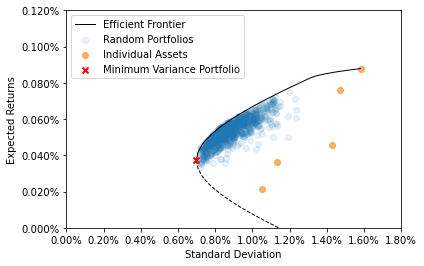

In [9]:
# Plot the expected returns and standard deviation
fig3 = plt.figure(figsize=(6,4))
plt.plot(frontier_long['Risks'], frontier_long['Returns'], 'k-',linewidth=1, alpha=1, label="Efficient Frontier")
plt.plot(frontier_long['Risks'], (2*frontier_long['Returns'].min()-frontier_long['Returns']), 'k--', linewidth=1, alpha=1)
plt.scatter(portfolio_sds, portfolio_returns, alpha=0.1, c='C0', label="Random Portfolios")
plt.scatter(stock_sds, stock_returns, alpha=0.6, c='C1', label="Individual Assets")
plt.scatter(frontier_long['Risks'].head(1), frontier_long['Returns'].head(1), marker='x', lw=2, c='r', zorder=100, label="Minimum Variance Portfolio")
plt.xlim(0, 0.018)
plt.ylim(0, 0.0012)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')
plt.show()    

The slight kink around the 1.3% standard deviation level results from the constraint prohibiting short selling impacting our returns, we will see in the next section that if we relax this constraint the kink dissappears and our opportunity set expands.

The Two Mutual Fund Theorem states that, given any two portfolios on the efficient frontier, we can generate any other portfolio on the frontier with the given portfolios.  One can expect that by holding a combination of two efficient frontier portfolios the resulting portfolio would have a risk level somewhere in between the them, the reason the return isn't then on the straight line segment connecting the existing portfolios is due to correlation between the assets.

In the final part of this section we look in closer detail at the portfolios along the efficient frontier of the securities within them.

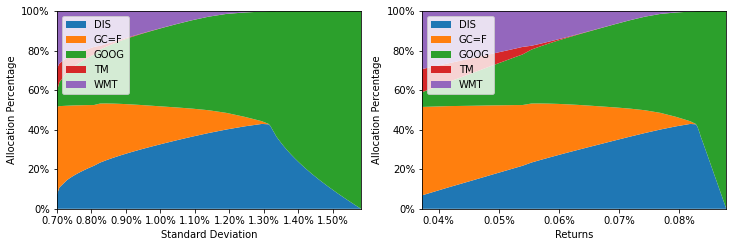

In [10]:
tm_weights = [row[0] for row in frontier_long['Weights']]
goog_weights = [row[1] for row in frontier_long['Weights']]
wmt_weights = [row[2] for row in frontier_long['Weights']]
dis_weights = [row[3] for row in frontier_long['Weights']]
gcf_weights = [row[4] for row in frontier_long['Weights']]


fig4 = plt.subplots(ncols = 2, nrows = 1, figsize=(12,8))

# Plot the allocation against standard deviation
plt.subplot(2,2,1)
plt.stackplot(frontier_long['Risks'], tm_weights, goog_weights, wmt_weights, dis_weights, gcf_weights, labels = tickers)
plt.xlim(frontier_long['Risks'].min(), frontier_long['Risks'].max())
plt.ylim(0, 1.0)
plt.ylabel('Allocation Percentage')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')

# Plot the allocation against expected returns
plt.subplot(2,2,2)
plt.stackplot(frontier_long['Returns'], tm_weights, goog_weights, wmt_weights, dis_weights, gcf_weights, labels = tickers)
plt.xlim(frontier_long['Returns'].min(), frontier_long['Returns'].max())
plt.ylim(0, 1.0)
plt.ylabel('Allocation Percentage')
plt.xlabel('Returns')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')

plt.show()   

We can see that as we move towards a greater return (and greater risk) the portfolio shifts weight away from the lower return (and lower risk) securities TM, WMT and GC=F and into DIS and GOOG.

## The Efficient Frontier (With Short Selling)

Now we relax the condition prohibiting short selling.

$$
\begin{align*}
\text{min } &\frac{1}{2}w^T\Sigma w \\
\text{s.t. } &w^TR = m\\
&w^T\mathbf{1} = 1
\end{align*}
$$

Since all the constraints are equalities this problem can be solved simply using Lagrangian Multipliers, please see the appendix for the derivation.

In [11]:
def weights_from_lambdas(returns, lambdas):
    n_assets = returns.shape[1]
    Sigma_mat = np.cov(returns, rowvar=False)
    Sigma_mat_inv = np.linalg.inv(Sigma_mat)
    R_vec = np.mean(returns)
    Ones_vec = np.ones(n_assets)
    
    weights = lambdas[0] * Sigma_mat_inv @ R_vec + lambdas[1] * Sigma_mat_inv @ Ones_vec
    return weights

def frontier_portfolios_short(returns):
    n_assets = returns.shape[1]
    Sigma_mat = np.cov(returns, rowvar=False)
    Sigma_mat_inv = np.linalg.inv(Sigma_mat)
    R_vec = np.mean(returns)
    Ones_vec = np.ones(n_assets)
    
    X_mat = np.matrix([[ R_vec.T @ Sigma_mat_inv @ R_vec,     R_vec.T @ Sigma_mat_inv @ Ones_vec   ], 
                       [ Ones_vec.T @ Sigma_mat_inv @ R_vec,  Ones_vec.T @ Sigma_mat_inv @ Ones_vec]])
    X_mat_inv = np.linalg.inv(X_mat)
    
    target_returns = np.linspace(0, 0.001, num=200)
    portfolio_weights = [weights_from_lambdas(returns, np.array(X_mat_inv @ np.array([target_return, 1]))[0]) for target_return in target_returns]
    returns = [R_vec @ weight for weight in portfolio_weights]
    risks = [np.sqrt(weight.T @ Sigma_mat @ weight) for weight in portfolio_weights]
    
    return returns, risks, portfolio_weights
    
returns, risks, weights = frontier_portfolios_short(df_returns)

min_var_portfolio_return = returns[np.argmin(risks)]
frontier_short = pd.DataFrame({'Risks':risks, 'Returns':returns, 'Weights':weights})
frontier_short_efficient = frontier_short[frontier_short['Returns'] >= min_var_portfolio_return]
frontier_short_inefficient = frontier_short[frontier_short['Returns'] < min_var_portfolio_return]

And again, now that we have the efficient frontier (and the inefficient frontier), we plot this over the top of our previous graph to show how the frontier with short selling differs when we relax short selling restrictions.

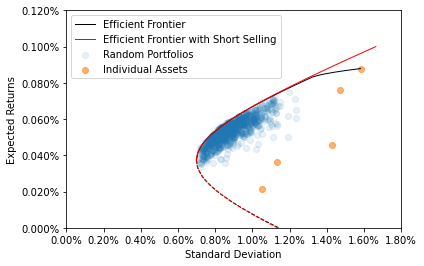

In [12]:
# Plot the expected returns and standard deviation
fig5 = plt.figure(figsize=(6,4))
plt.plot(frontier_long['Risks'], frontier_long['Returns'], 'k-',linewidth=1, alpha=1, label="Efficient Frontier")
plt.plot(frontier_long['Risks'], (2*frontier_long['Returns'].min()-frontier_long['Returns']), 'k--', linewidth=1, alpha=1)
plt.plot(frontier_short_efficient['Risks'], frontier_short_efficient['Returns'], 'k-',linewidth=1, alpha=1, c='r', label="Efficient Frontier with Short Selling")
plt.plot(frontier_short_inefficient['Risks'], frontier_short_inefficient['Returns'], 'k--',linewidth=1, alpha=1, c='r')
plt.scatter(portfolio_sds, portfolio_returns, alpha=0.1, c='C0', label="Random Portfolios")
plt.scatter(stock_sds, stock_returns, alpha=0.6, c='C1', label="Individual Assets")
plt.xlim(0, 0.018)
plt.ylim(0, 0.0012)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')
plt.show()    

## Introducting a Risk-Free Asset

A risk-free asset allows us to increase our opportunity set (i.e. the set of optimal investment opportunities), these additional opportunities lie along the what is known as the Capital Allocation Line (CAL).  

Obviously a completely risk-free asset doesn't exist in the real world but short rate Government Bonds act as a fairly good proxy.  We use a risk-free rate of 0.82% per annum, this was the yield on 10-year UK Government Bonds at EOY 2019.

In [13]:
from math import pow

# Risk-free rate calculations
r_f_yearly = 0.0082 # assumption
r_f_daily = pow(1+r_f_yearly,(1/365.0)) - 1

The CAL connects the portfolio containing only the risk-free asset to the 'Tangency Portfolio' on the efficient frontier.  The Tangency Portfolio is the portfolio on the line with the greatest Sharpe ratio, this is somewhat obvious as the Sharpe Ratio is simply the gradient of the CAL and so this gradient keeps increasing until we reach the point of tangency.

$$
S_P = \frac{\mathbb{E}[R_P] - r_f}{\sigma_P} \quad \text{(Sharpe Ratio)} 
$$

For interest we also printed the weights that make up the tangency portfolio.

In [14]:
# Search the tangency portfolios for the one with the maximal Sharpe ratio
Sharpe_ratios = np.array((frontier_long['Returns'] - r_f_daily)/frontier_long['Risks'])
max_Sharpe_ratio = np.argmax(Sharpe_ratios)
tangency_sd = frontier_long['Risks'].iloc[max_Sharpe_ratio]
tangency_return = frontier_long['Returns'].iloc[max_Sharpe_ratio]
tangency_weights = frontier_long['Weights'].iloc[max_Sharpe_ratio]
print([optimal_weights for optimal_weights in zip(tickers, 100*tangency_weights)])

[('DIS', 28.504186274346992), ('GC=F', 24.34127564779496), ('GOOG', 33.8085899513556), ('TM', 0.3585861909324938), ('WMT', 12.987361935569957)]


We finish by plotting the CAL on our previous frontier plots.  

By holding a combination of the risk-free asset and the tangency portfolio we are able to build a portfolio with a risk-return profile falling anywhere on the CAL.  Unlike in the Two Mutual Fund Theorem, where the combined portfolio isn't on the straight line segment between the two exisiting portfolios due to correlation, the risk-free asset is uncorrelated with any other investments by definition, so there is no additional benefit from correlation and hence a straight, not curved, line.

The dashed part of the CAL requires borrowing to build a leveraged portfolio, this is done under the assumption that borrowing and lending can both be done at the risk-free rate which isn't true in practise.  Thus, above the point of tangency the CAL would exhibit a shallower gradient in practise.

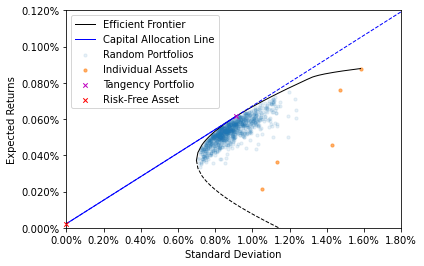

In [15]:
# Plot the expected returns and standard deviation
fig6 = plt.figure(figsize=(6,4))
plt.plot(frontier_long['Risks'], frontier_long['Returns'], 'k-', lw=1, alpha=1, label="Efficient Frontier")
plt.plot(frontier_long['Risks'], (2*frontier_long['Returns'].min()-frontier_long['Returns']), 'k--', linewidth=1, alpha=1)
plt.axline([0, r_f_daily], [tangency_sd, tangency_return], c='b', ls='--', lw=1)
plt.plot([0, tangency_sd], [r_f_daily, tangency_return], c='b', lw=1, label="Capital Allocation Line")
plt.scatter(portfolio_sds, portfolio_returns, alpha=0.1, s=10, c='C0', label="Random Portfolios")
plt.scatter(stock_sds, stock_returns, alpha=0.6, s=10, c='C1', label="Individual Assets")
plt.scatter(tangency_sd, tangency_return, marker='x', lw=1, c='m', s=20, zorder=100, label="Tangency Portfolio")
plt.scatter(0, r_f_daily, marker='x', lw=1, c='r', s=20, clip_on=False, zorder=100, label="Risk-Free Asset")
plt.xlim(0.0, 0.018)
plt.ylim(0.0, 0.0012)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3%}')) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.legend(loc='upper left')

plt.show() 

## Appendix

The below code cell enables equation numbering.

In [16]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
}) 

<IPython.core.display.Javascript object>

### Appendix A: Efficient frontier with short selling derivation

This section provides the mathematical derivation of the efficient frontier when short selling is allowed.  We start with the problem we are trying to solve.

$$
\begin{align*}
\text{min } &\frac{1}{2}w^T\Sigma w \\
\text{s.t. } &w^TR = m\\
&w^T\mathbf{1} = 1
\end{align*}
$$

Using Lagrangian multipliers our problem becomes,

$$
\min \mathcal{L}(w,\lambda_1,\lambda_2)\equiv \min \frac{1}{2}w^T\Sigma w - \lambda_1(w^TR - m) - \lambda_2(w^T\mathbf{1} - 1)
$$

Taking partial derivatives and setting them equal to 0,

$$
\begin{alignat}{2}
\frac{\partial\mathcal{L}}{\partial w}(w,\lambda_1,\lambda_2) &= \Sigma w - \lambda_1R - \lambda_2\mathbf{1} &= 0 \\
\frac{\partial\mathcal{L}}{\partial \lambda_1}(w,\lambda_1,\lambda_2) &= m - w^TR &= 0\\
\frac{\partial\mathcal{L}}{\partial \lambda_2}(w,\lambda_1,\lambda_2) &= 1 - w^T\mathbf{1} &= 0
\end{alignat}
$$

Then we re-arrange $(1)$ for $w$ to get $(4)$. Then pre-multiplying $(4)$ by $R^T$ we get $(5)$ and by $\mathbf{1}^T$ we get $(6)$.

$$
\begin{align}
w &= \lambda_1(\Sigma^{-1} R) + \lambda_2(\Sigma^{-1}\mathbf{1}) \\
m = R^Tw &= \lambda_1(R^T\Sigma^{-1} R) + \lambda_2(R^T\Sigma^{-1}\mathbf{1}) \\
1 = \mathbf{1}^Tw &= \lambda_1(\mathbf{1}^T\Sigma^{-1} R) + \lambda_2(\mathbf{1}^T\Sigma^{-1}\mathbf{1})
\end{align}
$$

We can rewrite $(5)$ and $(6)$ as a matrix multiplication which we can then solve for the Lagrange multipliers (the matrix $X$ is simply a relabelling to make our solution less verbose). 

$$
\begin{align*}
\begin{pmatrix} m \\ 1 \end{pmatrix} &= X \begin{pmatrix} \lambda_1 \\ \lambda_2 \end{pmatrix} := \begin{pmatrix} R^T\Sigma^{-1} R & R^T\Sigma^{-1}\mathbf{1} \\ \mathbf{1}^T\Sigma^{-1} R & \mathbf{1}^T\Sigma^{-1}\mathbf{1} \end{pmatrix} \begin{pmatrix} \lambda_1 \\ \lambda_2 \end{pmatrix} \\
&\implies \begin{pmatrix} \lambda_1 \\ \lambda_2 \end{pmatrix} = X^{-1} \begin{pmatrix} m \\ 1 \end{pmatrix}
\end{align*}
$$

Once we have the Lagrangian multiplier values, for a given value of $m$ we substitute back into $(4)$ to obtain the weights for that portfolio.  Note that we already have the portfolio expected return $m$ and the portfolio standard deviation is easy to calculate using the standard formula $\sigma_P = \sqrt{w^T\Sigma w}$.  

Sometimes this substitution is provided within the derivation and leads to one grandiose formula for $\sigma_P$ in terms of $m$, the proof to this point should make it clear how to do this if you deem it necessary.

NB. The final line of mathematical notation seems to render unusually when viewed on Github, with some of the vectors not appearing as columns.  It should be clear from the context what is meant and when run locally on your machine should render as expected.